In [1]:
import os
# to use or not to use GPU
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

# packages for model graph visualization
#!pip install -q pydot
# install graphviz https://graphviz.gitlab.io/download/ 

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
!pip install -q -U tensorflow-text
import tensorflow_text as text
!pip install -q tf-models-official
from official.nlp import optimization  # to create AdamW optimizer

import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt

#save_path = "/content/drive/My Drive/Colab Notebooks/"

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 213 kB 47.5 MB/s 
     |████████████████████████████████| 47.7 MB 56.0 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 99 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.2 MB/s 
     |████████████████████████████████| 352 kB 45.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
save_path = "/content/drive/My Drive/Colab Notebooks/"

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# checking if we have access to a GPU

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#@title Data Loading & Preprocessing


In [7]:
with open(save_path+'kafka_data_preprocessed_high_occurrence_50.json') as f:
    data = json.load(f)
    # shuffle data
    random.shuffle(data)
    # create description and assignee list
    desc_data = []
    assignee_data = []
    for item in data:
        desc_data.append(item['description'])
        assignee_data.append(item['assignee'])

In [8]:
print('sample assignees:', assignee_data[0:2])
print('sample descriptions:', desc_data[0:2])

sample assignees: ['Boyang Chen', 'Jason Gustafson']
sample descriptions: ['Inspired by discussion in [https://github.com/apache/kafka/pull/6762], we should attempt to shorten the time period from receiving the group deletion to actually remove it from cache. This saves the client unnecessary round trips to rebuild the group if needed.', 'The consumer coordinator communicates the need to rebalance through responses to heartbeat requests sent from each member of the consumer group. The heartbeat frequency therefore controls how long normal rebalances will take. Currently, the frequency is hard-coded to 3 heartbeats per the configured session timeout, but it would be nice to expose this setting so that the user can control the impact from rebalancing.Since the consumer is currently single-threaded and heartbeats are sent in poll(), we cannot guarantee that the heartbeats will actually be sent at the configured frequency. In practice, the user may have to adjust their fetch size to ensure

In [9]:
# transform description data to tensorflow dataset
descriptions = tf.data.Dataset.from_tensor_slices(desc_data)
for input in descriptions.take(2):
    print(input)

tf.Tensor(b'Inspired by discussion in [https://github.com/apache/kafka/pull/6762], we should attempt to shorten the time period from receiving the group deletion to actually remove it from cache. This saves the client unnecessary round trips to rebuild the group if needed.', shape=(), dtype=string)
tf.Tensor(b'The consumer coordinator communicates the need to rebalance through responses to heartbeat requests sent from each member of the consumer group. The heartbeat frequency therefore controls how long normal rebalances will take. Currently, the frequency is hard-coded to 3 heartbeats per the configured session timeout, but it would be nice to expose this setting so that the user can control the impact from rebalancing.Since the consumer is currently single-threaded and heartbeats are sent in poll(), we cannot guarantee that the heartbeats will actually be sent at the configured frequency. In practice, the user may have to adjust their fetch size to ensure that poll() is called often 

In [10]:
# target vectorize assignee data
assignee_dict = {assignee: i for i, assignee in enumerate(list(set(assignee_data)))}
assignee_dict



{'A. Sophie Blee-Goldman': 10,
 'Apurva Mehta': 27,
 'Ashish Singh': 4,
 'Bill Bejeck': 15,
 'Boyang Chen': 9,
 'Bruno Cadonna': 32,
 'Chia-Ping Tsai': 18,
 'Chris Egerton': 0,
 'Colin McCabe': 22,
 'Damian Guy': 11,
 'David Jacot': 16,
 'Dong Lin': 13,
 'Dongjin Lee': 8,
 'Eno Thereska': 2,
 'Ewen Cheslack-Postava': 5,
 'Grant Henke': 24,
 'Guozhang Wang': 19,
 'Gwen Shapira': 12,
 'Harsha': 31,
 'Ismael Juma': 29,
 'Jason Gustafson': 25,
 'Jay Kreps': 28,
 'Jiangjie Qin': 35,
 'John Roesler': 6,
 'Jun Rao': 33,
 'Konstantine Karantasis': 23,
 'Luke Chen': 30,
 'Manikumar': 17,
 'Matthias J. Sax': 14,
 'Neha Narkhede': 21,
 'Rajini Sivaram': 26,
 'Randall Hauch': 34,
 'Swapnil Ghike': 7,
 'Tom Bentley': 1,
 'Vahid Hashemian': 20,
 'huxihx': 3}

In [11]:
# create target vector
assignee_vector = [assignee_dict[assignee] for assignee in assignee_data]
assignee_vector[:10]

[9, 25, 26, 16, 16, 25, 32, 19, 25, 17]

In [12]:
# assignee target vector to one hot vector
assignee_tensor = tf.data.Dataset.from_tensor_slices(assignee_vector)
assignee_one_hot = assignee_tensor.map(lambda x: tf.one_hot(x, len(assignee_dict)))
for assignee in assignee_one_hot.take(5):
    print(assignee)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)


In [13]:
# zip descriptions and assignee for training
dataset = tf.data.Dataset.zip((descriptions, assignee_one_hot))
for input, target in dataset.take(2):
    print(input)
    print(target)

tf.Tensor(b'Inspired by discussion in [https://github.com/apache/kafka/pull/6762], we should attempt to shorten the time period from receiving the group deletion to actually remove it from cache. This saves the client unnecessary round trips to rebuild the group if needed.', shape=(), dtype=string)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(b'The consumer coordinator communicates the need to rebalance through responses to heartbeat requests sent from each member of the consumer group. The heartbeat frequency therefore controls how long normal rebalances will take. Currently, the frequency is hard-coded to 3 heartbeats per the configured session timeout, but it would be nice to expose this setting so that the user can control the impact from rebalancing.Since the consumer is currently single-threaded and heartbeats are sent in poll(), we cannot guarantee that the heartbe

In [14]:
# shuffle dataset
data_len = len(dataset)
dataset = dataset.shuffle(data_len)


In [15]:
# split dataset into train val and test
BATCH_SIZE = 32
VAL_SIZE = 0.15
n_examples = tf.data.experimental.cardinality(dataset).numpy()
print('n_examples:', n_examples)

VAL_SIZE = round(VAL_SIZE*n_examples)
test_dataset = dataset.take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_dataset = dataset.skip(VAL_SIZE).take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = dataset.skip(VAL_SIZE*2).batch(batch_size=BATCH_SIZE, drop_remainder=True)


n_examples: 4338


In [16]:
# prefetch train val and test dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print('len(train_dataset):', len(train_dataset))
print('len(val_dataset):', len(val_dataset))
print('len(test_dataset):', len(test_dataset))


len(train_dataset): 94
len(val_dataset): 20
len(test_dataset): 20


In [17]:
# some train dataset examples
for input, target in train_dataset.take(1):
    print(input)
    print(target)

tf.Tensor(
[b'If a RequestSendThread is shut down while waiting on the underlying Selector to return from a select() call, the Selector will swallow the interrupt, wake up and return immediately. NetworkClientUtils.sendAndReceive will then potentially re-poll the client, forcing the thread shutdown to wait for the request to complete. We should check the thread interrupt status before re-polling the client to prevent this delay.'
 b'New system tests as part of KAFKA-5725 with PR https://github.com/apache/kafka/pull/3656 consistently fail like this:[2017-08-14 10:37:57,216] ERROR User provided listener org.apache.kafka.streams.processor.internals.StreamThread$RebalanceListener for group SmokeTest failed on partition assignment (org.apache.kafka.clients.consumer.internals.ConsumerCoordinator)org.apache.kafka.streams.errors.ProcessorStateException: Error opening store cntStoreName at location /mnt/streams/SmokeTest/2_0/rocksdb/cntStoreName at org.apache.kafka.streams.state.internals.Rocks

In [18]:
#@title BOW


In [38]:
vectorize_layer = layers.TextVectorization(
    split = "whitespace",
    output_mode='multi_hot')

In [39]:
vectorize_layer.adapt(descriptions)

In [40]:
# printing vocabulary size and examples
print(vectorize_layer.vocabulary_size())
print(vectorize_layer.get_vocabulary()[0:439])

42790
['[UNK]', 'the', 'at', 'to', 'a', 'is', 'for', 'in', 'and', 'this', 'of', 'we', 'not', 'be', 'that', 'it', 'error', 'with', 'from', 'info', 'on', 'if', 'partition', 'are', 'when', 'will', 'topic', 'as', '1', 'broker', '0', 'kafka', 'offset', 'server', 'but', 'should', 'consumer', 'can', 'an', 'have', 'has', 'by', 'i', 'new', 'which', 'or', 'does', 'code', 'all', 'controller', '2', 'state', 'log', 'partitions', 'would', 'null', 'only', 'so', 'request', 'there', 'producer', 'group', 'host', 'use', 'time', 'topics', 'allow', 'data', 'was', 'one', '20191113', 'test', 'thread', 'some', 'topicpartition', 'set', 'message', 'failed', 'since', 'no', 'any', 'client', 'leader', 'after', 'currently', 'messages', 'replicafetcher', 'fetcherid0', 'operations', '3', 'brokers', 'method', 'orgapachekafkacommonerrorsunknowntopicorpartitionexception', 'exception', 'its', 'hosts', 'could', 'kafkaserverreplicafetcherthread76', 'following', 'kafkacontrollerkafkacontroller66', 'then', 'permission', 'fil

In [41]:
for line in descriptions.take(2):
    print(line)
    print(vectorize_layer(line))

tf.Tensor(b'Inspired by discussion in [https://github.com/apache/kafka/pull/6762], we should attempt to shorten the time period from receiving the group deletion to actually remove it from cache. This saves the client unnecessary round trips to rebuild the group if needed.', shape=(), dtype=string)
tf.Tensor([0. 1. 0. ... 0. 0. 0.], shape=(42790,), dtype=float32)
tf.Tensor(b'The consumer coordinator communicates the need to rebalance through responses to heartbeat requests sent from each member of the consumer group. The heartbeat frequency therefore controls how long normal rebalances will take. Currently, the frequency is hard-coded to 3 heartbeats per the configured session timeout, but it would be nice to expose this setting so that the user can control the impact from rebalancing.Since the consumer is currently single-threaded and heartbeats are sent in poll(), we cannot guarantee that the heartbeats will actually be sent at the configured frequency. In practice, the user may have

In [37]:
bow_dataset = tf.data.Dataset.zip((descriptions, assignee_one_hot))
for line, label in bow_dataset.take(2):
    print(line, label)

tf.Tensor(b'Inspired by discussion in [https://github.com/apache/kafka/pull/6762], we should attempt to shorten the time period from receiving the group deletion to actually remove it from cache. This saves the client unnecessary round trips to rebuild the group if needed.', shape=(), dtype=string) tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(b'The consumer coordinator communicates the need to rebalance through responses to heartbeat requests sent from each member of the consumer group. The heartbeat frequency therefore controls how long normal rebalances will take. Currently, the frequency is hard-coded to 3 heartbeats per the configured session timeout, but it would be nice to expose this setting so that the user can control the impact from rebalancing.Since the consumer is currently single-threaded and heartbeats are sent in poll(), we cannot guarantee that the heartbe

In [47]:
embedding_dim=64
vocab_size = vectorize_layer.vocabulary_size()
bow_model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(len(assignee_dict))
])

BERT MODEL

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

# find more models and preprocessing maps at 
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# preprocessing examples
text_test = [input[0].numpy(), input[1].numpy()]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Lines      : {text_test}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   :')
print(f'{text_preprocessed["input_word_ids"][:, :12]}')
print(f'Input Mask :')
print(f'{text_preprocessed["input_mask"][:, :12]}')
print(f'Type Ids   :')
print(f'{text_preprocessed["input_type_ids"][:, :12]}')


Lines      : [b'When calling kafkaStreams.cleanUp() before starting a stream the StateDirectory.cleanRemovedTasks() method contains this check: {code:java} ... Line 240 if (lock(id, 0)) { long now = time.milliseconds(); long lastModifiedMs = taskDir.lastModified(); if (now > lastModifiedMs + cleanupDelayMs) { log.info("{} Deleting obsolete state directory {} for task {} as {}ms has elapsed (cleanup delay is {}ms)", logPrefix(), dirName, id, now - lastModifiedMs, cleanupDelayMs); Utils.delete(taskDir); } } {code} The check for lock(id,0) will create a .lock file in the directory that subsequently is going to be deleted. If the .lock file already exists from a previous run the attempt to delete the .lock file fails with AccessDeniedException. This leaves the .lock file in the taskDir. Calling Utils.delete(taskDir) will then attempt to remove the taskDir path calling Files.delete(path). The call to files.delete(path) in postVisitDirectory will then fail java.nio.file.DirectoryNotEmptyExce

In [ ]:
# model output examples

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Sequence Outputs Shape:(2, 128, 128)
Sequence Outputs Values:[[-1.4380822   0.61638653 -3.4004095  ... -1.364798   -1.3828596
   0.70223975]
 [-0.8955519   0.80287147 -0.15204875 ... -1.420144   -1.5461118
  -0.36137325]
 [-1.7235746   0.1381334   0.5011973  ... -1.8087068  -1.9490887
   2.5663202 ]
 ...
 [-1.910712    0.91843057 -0.4172927  ... -2.4141307  -0.7308235
   1.7462286 ]
 [-1.309943    0.46693093  0.17744386 ... -2.61881    -0.6973785
   1.12577   ]
 [-1.1666124   1.160274    0.57910633 ... -1.086322   -0.70696485
   0.8000298 ]]
Pooled Outputs Shape:(2, 128)
Pooled Outputs Values:[-0.9998916   0.02328855 -0.97408205 -0.5549644  -0.61651963  0.5181036
 -0.628521   -0.93614066 -0.01959738  0.00820493 -0.65850854 -0.07694539]


Classifier

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output'] 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(len(assignee_dict), activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# building the classifier

bug_assignee_classifier = build_classifier_model()

bug_assignee_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# classifier output examples

bert_raw_result = bug_assignee_classifier(tf.constant(text_test))
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.03280021 0.09556007 0.00671507 0.00500462 0.06518464 0.01725408
  0.00364592 0.01622348 0.02228893 0.01233388 0.06069117 0.03115115
  0.00559859 0.00693555 0.00781763 0.06171735 0.00417901 0.0167407
  0.03812569 0.00634878 0.05924654 0.00627553 0.02032497 0.03011253
  0.02505058 0.03515192 0.01972057 0.01256518 0.0236555  0.09355708
  0.01477978 0.10632806 0.01404069 0.00431235 0.01402462 0.00453758]
 [0.02605566 0.09598196 0.00618016 0.00423713 0.06562345 0.01326334
  0.00648352 0.01290798 0.02019427 0.01335619 0.03486516 0.0197282
  0.0025335  0.00455382 0.0077836  0.04582523 0.00356163 0.02258001
  0.04053425 0.00833934 0.06209866 0.00692899 0.02298669 0.03270593
  0.04594782 0.02843216 0.023755   0.01101229 0.0411468  0.14189485
  0.02363653 0.0645661  0.01479621 0.00322239 0.01922868 0.00305247]], shape=(2, 36), dtype=float32)


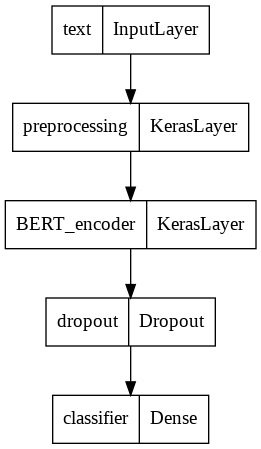

In [ ]:
# plotting the model (requires pydot and graphviz)
tf.keras.utils.plot_model(bug_assignee_classifier)

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs

# Here we are using AdamW with a linear learning rate schedule.
# Because of the rolling averages in the optimization logic we need a few warm up steps.
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio*num_train_steps)
init_lr = 1e-3

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy()

# compiling the model
bug_assignee_classifier.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


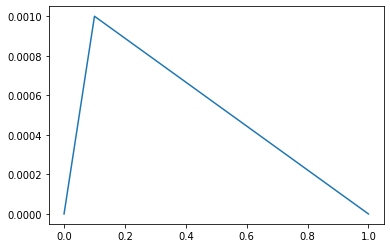

In [ ]:
# visualizing our learning rate schedule
x = np.array([0,warmup_ratio,1])
y = np.array([0, init_lr,0])
plt.plot(x,y)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bug_assignee_classifier.fit(x=train_dataset,
                               validation_data=val_dataset,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/15
94/94 [==============================] - 24s 206ms/step - loss: 3.5847 - categorical_accuracy: 0.0698 - val_loss: 3.3127 - val_categorical_accuracy: 0.1187
Epoch 2/15
94/94 [==============================] - 18s 195ms/step - loss: 3.2301 - categorical_accuracy: 0.1307 - val_loss: 2.8848 - val_categorical_accuracy: 0.2313
Epoch 3/15
94/94 [==============================] - 19s 198ms/step - loss: 2.8546 - categorical_accuracy: 0.2061 - val_loss: 2.4421 - val_categorical_accuracy: 0.2953
Epoch 4/15
94/94 [==============================] - 19s 196ms/step - loss: 2.4139 - categorical_accuracy: 0.3205 - val_loss: 1.8900 - val_categorical_accuracy: 0.4484
Epoch 5/15
94/94 [==============================] - 19s 198ms/step - loss: 1.9809 - categorical_accuracy: 0.4362 - val_loss: 1.3201 - val_categorical_accuracy: 0.6641
Epoch 6/15
94/94 [==============================] - 18s 195ms/step - loss

In [ ]:
loss, accuracy = bug_assignee_classifier.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

20/20 [==============================] - 3s 140ms/step - loss: 0.0355 - categorical_accuracy: 0.9969
Loss: 0.0355026051402092
Accuracy: 0.996874988079071


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


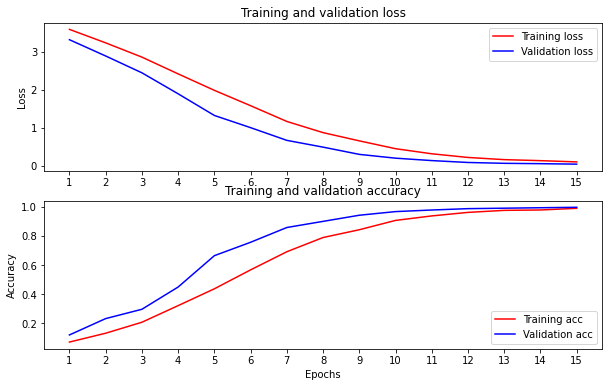

In [ ]:
# plotting accuracy and loss history

history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
#fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
#plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

Save Bert Model

In [ ]:
# saving 

saved_model_path = save_path + "bug_assignee_prediction_bert_model"
bug_assignee_classifier.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bug_assignee_prediction_bert_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bug_assignee_prediction_bert_model/assets


RNN

In [ ]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'the', ..., 'disappeared', 'dirname', 'differentiate'],
      dtype='<U4531')

In [ ]:
rnn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(assignee_dict))
])

In [ ]:
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = rnn_model.fit(train_dataset, epochs=20,
                    validation_data=val_dataset)

Epoch 1/20
94/94 [==============================] - 58s 416ms/step - loss: 3.4512 - accuracy: 0.0811 - val_loss: 3.3648 - val_accuracy: 0.0938
Epoch 2/20
94/94 [==============================] - 36s 377ms/step - loss: 3.3321 - accuracy: 0.0984 - val_loss: 3.1273 - val_accuracy: 0.1359
Epoch 3/20
94/94 [==============================] - 36s 377ms/step - loss: 3.1254 - accuracy: 0.1187 - val_loss: 2.9759 - val_accuracy: 0.1172
Epoch 4/20
94/94 [==============================] - 37s 396ms/step - loss: 2.9198 - accuracy: 0.1626 - val_loss: 2.7485 - val_accuracy: 0.1953
Epoch 5/20
94/94 [==============================] - 37s 390ms/step - loss: 2.6946 - accuracy: 0.2234 - val_loss: 2.5086 - val_accuracy: 0.2750
Epoch 6/20
94/94 [==============================] - 39s 413ms/step - loss: 2.4281 - accuracy: 0.2886 - val_loss: 2.1324 - val_accuracy: 0.3766
Epoch 7/20
94/94 [==============================] - 36s 386ms/step - loss: 2.1806 - accuracy: 0.3587 - val_loss: 2.0112 - val_accuracy: 0.4328

In [ ]:
test_loss, test_acc = rnn_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

20/20 [==============================] - 3s 139ms/step - loss: 0.2275 - accuracy: 0.9500
Test Loss: 0.22747404873371124
Test Accuracy: 0.949999988079071


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


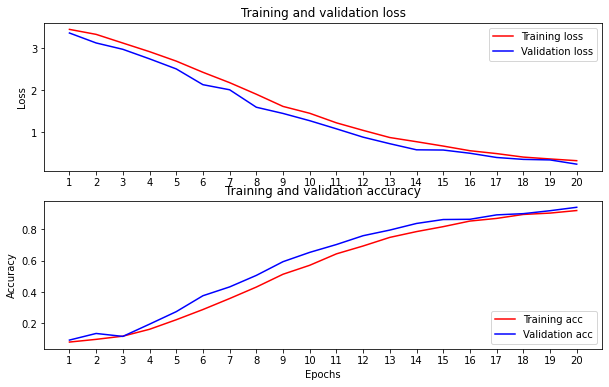

In [ ]:
# plotting accuracy and loss history

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
#fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
#plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');